# Baseline - logistic regression

In [3]:
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from scipy.special import expit
import pandas as pd
import numpy as np
import seaborn as sns
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG


import warnings
warnings.filterwarnings("ignore")

## Classifier

In [59]:
import os
import pandas as pd 
from sklearn import metrics
from sklearn import tree 
import argparse

def run(fold, model):
    # read the training data with folds
    df = pd.read_csv('/home/jupyter/charliemacuject/research_papers/dme/input/df_train_folds.csv')

    # training data is where kfold is not equal to provided fold
    # also, note that we reset the index
    df_train = df[df.kfold != fold].reset_index(drop=True)

    # validation data is where kfold is equal to provided fold
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    # drop the label column from dataframe and convert it to
    # a numpy array by using .values
    # target is label column in the dataframe
    x_train = df_train.drop("outcome", axis=1).values
    y_train = df_train.outcome.values

    # similarly, for validation we have
    x_valid = df_valid.drop("outcome", axis=1).values
    y_valid = df_valid.outcome.values

    # initialises model
    clf = model

    # fit the model on training data
    clf.fit(x_train, y_train)

    # create predictions for validation samples
    preds = clf.predict(x_valid)

    # calculate metrics and print
    accuracy = metrics.accuracy_score(y_valid, preds)
    print("Fold={}, Accuracy={}".format(fold, accuracy))

In [40]:
for i in range(5):
    run(fold=i, model=tree.DecisionTreeClassifier())

Fold=0, Accuracy=0.76
Fold=1, Accuracy=0.86
Fold=2, Accuracy=0.8
Fold=3, Accuracy=0.84
Fold=4, Accuracy=0.68


In [44]:
from sklearn.ensemble import RandomForestClassifier

for i in range(5):
    run(fold=i, model=RandomForestClassifier())

Fold=0, Accuracy=0.82
Fold=1, Accuracy=0.92
Fold=2, Accuracy=0.84
Fold=3, Accuracy=0.9
Fold=4, Accuracy=0.8


In [47]:
for i in range(5):
    run(fold=i, model=linear_model.LogisticRegression())

Fold=0, Accuracy=0.94
Fold=1, Accuracy=0.92
Fold=2, Accuracy=0.86
Fold=3, Accuracy=0.98
Fold=4, Accuracy=0.8


## Decision tree

In [5]:
df_train = pd.read_csv('/home/jupyter/charliemacuject/research_papers/dme/input/df_train.csv')
df_train.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
df_test = pd.read_csv('/home/jupyter/charliemacuject/research_papers/dme/input/df_test.csv')
df_test.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

In [6]:
df_test.columns

Index(['mean_vision', 'time_above_baseline', 'peak_visual_improvement',
       'time_to_peak', 'baseline', 'visits', 'time_since_starting', 'location',
       'id', 'outcome'],
      dtype='object')

In [7]:
X_train = df_train.drop(columns=['outcome', 'id'])
y_train = df_train.outcome
X_test = df_test.drop(columns=['outcome', 'id'])
y_test = df_test.outcome

We use one-hot encoding to represent categorical variables:

In [8]:
X_train = pd.concat([X_train, pd.get_dummies(X_train.location)], axis=1)
X_train.drop(columns=['location'], inplace=True)
X_test = pd.concat([X_test, pd.get_dummies(X_test.location)], axis=1)
X_test.drop(columns=['location'], inplace=True)

In [9]:
X_train.head()

,mean_vision,time_above_baseline,peak_visual_improvement,time_to_peak,baseline,visits,time_since_starting,boronia,box_hill
0,76.560000,959,10.0,232,70.0,25,959,1,0
1,77.027397,0,0.0,0,94.0,73,2812,1,0
2,74.000000,0,0.0,0,76.0,6,593,0,1
3,67.947368,793,9.0,756,76.0,38,1813,0,1
4,66.818182,0,0.0,0,70.0,11,304,0,1


In [86]:
m = DecisionTreeClassifier(max_leaf_nodes = 4)
m.fit(X_train, y_train);

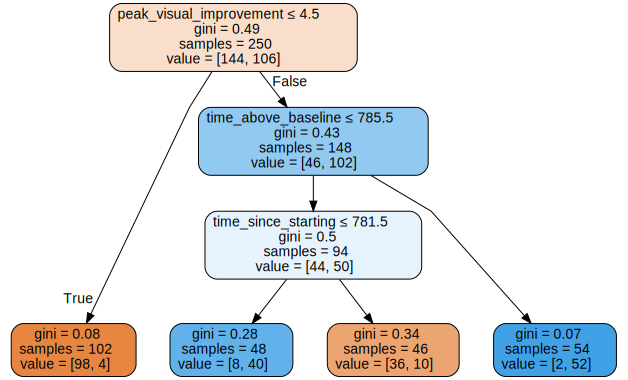

In [87]:
draw_tree(m, X_train, size=10, leaves_parallel=True, precision = 2)

In [88]:
def accuracy(y_true, y_pred):
    correct_counter = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == yp:
            correct_counter += 1
    return round(correct_counter / len(y_true), 5)

In [89]:
def m_accuracy(m, X, y): 
    return accuracy(m.predict(X), y)

In [90]:
m_accuracy(m, X_train, y_train)

0.904

In [91]:
from sklearn.metrics import accuracy_score
accuracy_score(m.predict(X_test), y_test)

0.7887323943661971

Let's train a bigger model.

In [92]:
m = DecisionTreeClassifier()
m.fit(X_train, y_train)

DecisionTreeClassifier()

In [93]:
m_accuracy(m, X_train, y_train)

1.0

In [94]:
m_accuracy(m, X_test, y_test)

0.77465

In [95]:
m.get_n_leaves(), len(X_train)

(24, 250)

In this case, it doesn't appear we're overfitting too badly. The validation accuracy has actually gone up since adding more leaves. Additionally, the number of leaves is nowhere near the number of training examples.

## Random forest

In [96]:
def rf(xs, y, n_estimators=40, max_samples=250,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True, warm_start=True).fit(xs, y)

In [97]:
m = rf(X_train, y_train)
m_accuracy(m, X_train, y_train), m_accuracy(m, X_test, y_test)

(0.96, 0.83099)

Our validation RMSE is now much improved over our last result using a decision tree, which made just one tree using all the available data.

To see the impact of `n_estimators`, let's get the predictions from each individual tree in our forest:

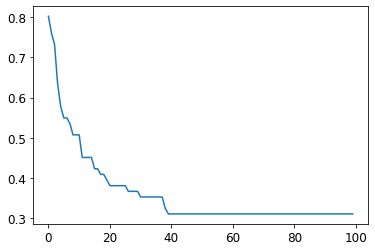

In [40]:
plt.plot([accuracy(preds[:i+1].mean(0), y_test) for i in range(100)]);

### Tree variance

In [101]:
m.predict(X_test)

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1])

In [102]:
preds = np.stack([t.predict(X_test) for t in m.estimators_])

In [103]:
preds.shape

(40, 71)

Now we have a prediction for every tree and every patient (40 trees and 71 patients) in the validation set. Using this, we can get the standard deviation of the predictions over all the trees, for each patient:

In [107]:
preds_std = preds.std(0)
preds_std

array([0.35707142, 0.        , 0.35707142, 0.        , 0.41758233, 0.15612495, 0.15612495, 0.3799671 , 0.4330127 , 0.        , 0.21794495, 0.35707142, 0.45825757, 0.15612495, 0.26339134, 0.35707142,
       0.4769696 , 0.21794495, 0.        , 0.3799671 , 0.44651428, 0.46837485, 0.35707142, 0.        , 0.        , 0.3799671 , 0.        , 0.        , 0.33071891, 0.33071891, 0.3       , 0.26339134,
       0.        , 0.21794495, 0.4       , 0.15612495, 0.        , 0.3799671 , 0.5       , 0.        , 0.        , 0.        , 0.        , 0.49937461, 0.48412292, 0.49937461, 0.494343  , 0.        ,
       0.45825757, 0.        , 0.48412292, 0.15612495, 0.35707142, 0.4769696 , 0.33071891, 0.        , 0.        , 0.        , 0.        , 0.        , 0.26339134, 0.        , 0.41758233, 0.3799671 ,
       0.4       , 0.26339134, 0.33071891, 0.4330127 , 0.41758233, 0.4       , 0.3799671 ])

As we can see, the confidence in the predictions varies widely. For some patients, there is no standard deviation, because all the trees agree. For others it's higher, as the trees don't agree. This information would be useful in a clinical-support setting; for instance, if tree variance was high for a particular patient, you would be wary of using the overall prediction in any clinical decision.

In [108]:
np.mean(preds_std)

0.24786740393801826

### Feature importance

In [98]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols': df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [99]:
fi = rf_feat_importance(m, X_train)
fi

,cols,imp
1,time_above_baseline,0.341497
2,peak_visual_improvement,0.306271
6,time_since_starting,0.114199
3,time_to_peak,0.093326
5,visits,0.077117
0,mean_vision,0.041221
4,baseline,0.024731
7,boronia,0.001608
8,box_hill,0.000030


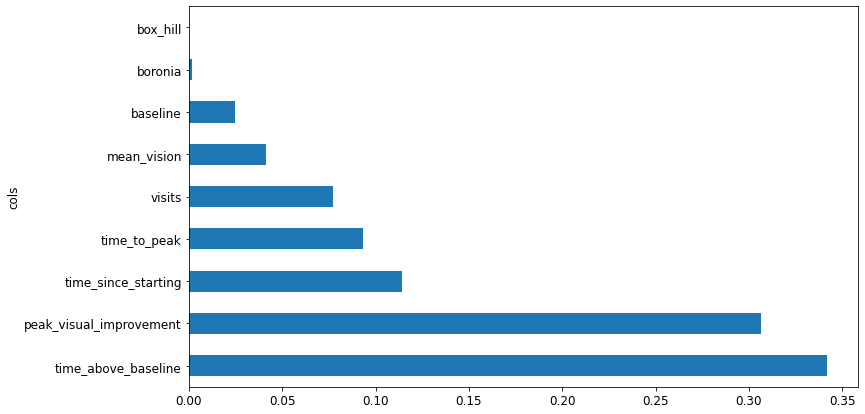

In [100]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

### Partial dependence

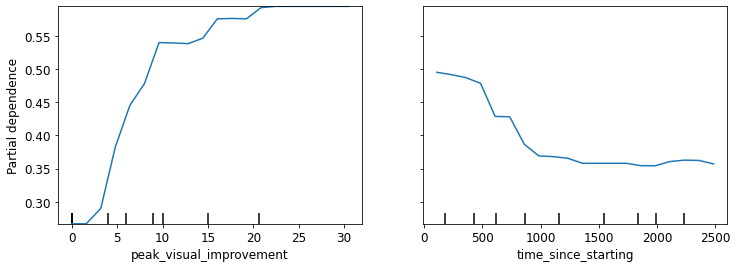

In [111]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, X_train, ['peak_visual_improvement','time_since_starting'],
                        grid_resolution=20, ax=ax);

### Redundant features

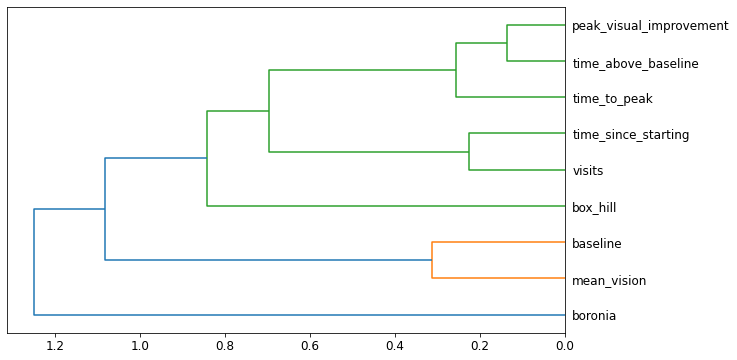

In [109]:
cluster_columns(X_train)

### How do certain factors influence prediction

In [112]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [113]:
row = X_test.iloc[:5]

In [114]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [128]:
a = contributions[1]
a

array([[ 0.00173179, -0.00173179],
       [ 0.16469447, -0.16469447],
       [ 0.15464208, -0.15464208],
       [ 0.06682314, -0.06682314],
       [ 0.00940637, -0.00940637],
       [ 0.01015561, -0.01015561],
       [ 0.00550368, -0.00550368],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

In [131]:
b = [0.00173179, 0.16469447, 0.15464208,
     0.06682314, 0.00940637, 0.01015561, 
     0.00550368, 0.0, 0.0]

In [123]:
prediction[1], bias[1], contributions[1].sum()

(array([0.99285714, 0.00714286]),
 array([0.5799, 0.4201]),
 -1.734723475976807e-18)

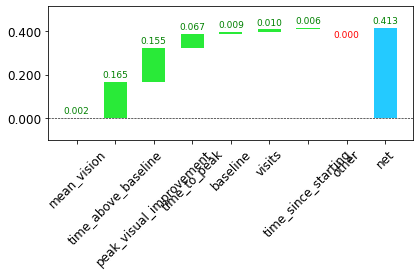

In [132]:
waterfall(X_test.columns, b, threshold=0.001, 
          rotation_value=45,formatting='{:,.3f}');

## Neural net

Sometimes it is hard to know whether your test set is distributed in the same way as your training data, or, if it is different, what columns reflect that difference. There's actually an easy way to figure this out, which is to use a random forest!

But in this case we don't use the random forest to predict our actual dependent variable. Instead, we try to predict whether a row is in the validation set or the training set. To see this in action, let's combine our training and validation sets together, create a dependent variable that represents which dataset each row comes from, build a random forest using that data, and get its feature importance:

In [10]:
df_dom = pd.concat([X_train, X_test])
is_valid = np.array([0]*len(X_train) + [1]*len(X_test))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

NameError: name 'rf' is not defined

In [4]:
df_nn = pd.read_csv('/home/jupyter/charliemacuject/research_papers/dme/input/df_features.csv', low_memory=False)
df_nn.drop(columns=['Unnamed: 0', 'overall_visual_change'], inplace=True)
df_nn.columns

Index(['mean_vision', 'time_above_baseline', 'peak_visual_improvement',
       'time_to_peak', 'baseline', 'visits', 'time_since_starting', 'location',
       'id', 'outcome'],
      dtype='object')

In [5]:
df_nn.outcome = df_nn.outcome + 1

In [6]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df_nn))

In [7]:
df_nn.drop(columns=['id'], inplace=True)

In [8]:
dep_var = 'outcome'

In [9]:
cont_nn,cat_nn = cont_cat_split(df_nn, max_card=9000, dep_var=dep_var)

In [10]:
cont_nn

['mean_vision', 'peak_visual_improvement', 'baseline']

In [11]:
cat_nn

['time_above_baseline',
 'time_to_peak',
 'visits',
 'time_since_starting',
 'location']

In [12]:
cont_nn.extend(['time_above_baseline',
 'time_to_peak',
 'visits',
 'time_since_starting'])

In [13]:
cont_nn

['mean_vision',
 'peak_visual_improvement',
 'baseline',
 'time_above_baseline',
 'time_to_peak',
 'visits',
 'time_since_starting']

In [14]:
cat_nn = ['location']

In [15]:
df_nn.head()

,mean_vision,time_above_baseline,peak_visual_improvement,time_to_peak,baseline,visits,time_since_starting,location,outcome
0,70.064516,0,0.0,0,76.0,31,1532,box_hill,1
1,71.062500,0,0.0,0,85.0,16,1156,box_hill,1
2,72.562500,0,0.0,0,85.0,16,1156,box_hill,1
3,77.448276,2036,20.0,987,65.0,29,2036,box_hill,2
4,73.689655,225,4.0,1829,76.0,29,2036,box_hill,2


In [63]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var, 
                      y_block = CategoryBlock())

In [64]:
dls=to_nn.dataloaders(256)

In [65]:
learn = tabular_learner(dls, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time
0,0.235023,0.483030,0.781250,00:00
1,0.232499,0.426744,0.812500,00:00
2,0.220586,0.399013,0.812500,00:00


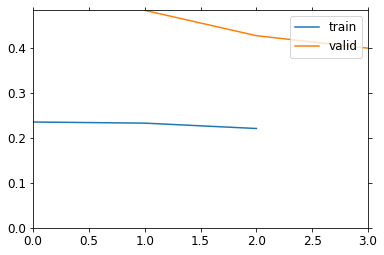

In [70]:
learn.fit_one_cycle(3, 1e-2,cbs=[ShowGraphCallback()])

In [71]:
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

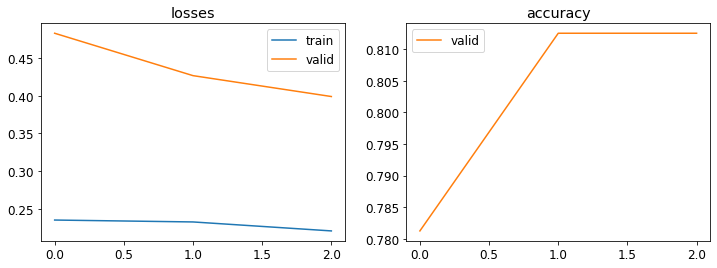

In [72]:
learn.recorder.plot_metrics()